# Fit PRDX1 koffs and kons

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Writes Barranco-Medina 2008 Fig. 1c PRDX1 injection parameters (filename: `ITC_PRDX1_inject_params.csv`)

Performs regression on ITC data digitized from Barranco-Medina et al. 2008 to fit the kon and koff of Prx decamer formation.

Writes fitted koff and kon (filename: `fitted_koff_kon_PRDX1_params.csv`)

Performs regression on ITC data digitized from Barranco-Medina et al. 2008 to fit the kon and koff **and Kd** of Prx decamer formation.

Writes fitted **Kd**, koff, and kon (filename: `fitted_Kd_koff_kon_PRDX1_params.csv`)

Performs identifyability analysis on the fits of kon and koff **and Kd**



**Requirements:**

Python libraries (see **Imports** below)

ITC Prx model (filename:`ITC_Prx_dim-dec.psc`)

ITC model parameters (filename: `ITC_data_PRDX1_processed.csv`)

**Note:**

The identifyability analysis is computationally intensive when performed in a Jupyter notebook. Therefore a script (filename:`script_identi_koff_Kdapp_PRDX1.py`) has been written to perform the identifyability analysis in python.

To perform the identifyability analysis of this notebook:

    1. Run the notebook
    
    2. Run the identifyability script
    
    3. Run the notebook again


##### Imports

In [1]:
import os
import math
import copy
import gc

import dill as pickle
import scipy as sp
import numpy as np
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import auc
from scipy.interpolate import interp1d

import pysces
from identifiability import conf_interval


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Save directories

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

multiplier = 1
mpl_width = 4.5*multiplier
mpl_height = 3.5*multiplier
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"

###### Fitting methods

In [4]:
# fitting_method = "nelder"
fitting_method = "leastsq"

## Barranco-Medina et al. 2008 PRDX1 

### data

In [5]:
df_PRDX1 = pd.read_csv(os.path.join(prev_dir,"ITC_data","ITC_data_PRDX1_processed.csv")).set_index('Time (sec)')

### Inject params

In [6]:
# Values from Barranco-Medina 2008
inj_enthalpy_PRDX1 = 156
inj_volume_PRDX1 = 1.6 # ul
inj_mon_PRDX1 = 102 # uM MONOMERS
inj_dim_est_PRDX1 = 0.8
inj_dec_est_PRDX1 = (inj_mon_PRDX1/2 - 0.8)/5
inj_interval_PRDX1 = 200 # sec


In [7]:
# Create df used to update models later
columns = ["Parameter","Value"]
df_ITC_PRDX1_inject_params = pd.DataFrame(columns = columns)

entry = {"Parameter": [ "injection_enthalpy",
                        "injection_volume",
                        "injection_Prx_mon",
                        "injection_dimer",
                        "injection_decamer",
                        "injection_interval",
                        "first_inject_ratio"],
         
       "Value":[inj_enthalpy_PRDX1,
                inj_volume_PRDX1,
                inj_mon_PRDX1,
                inj_dim_est_PRDX1, 
                inj_dec_est_PRDX1,
                inj_interval_PRDX1,
                1]}

entry = pd.DataFrame(entry)
df_ITC_PRDX1_inject_params = pd.concat([df_ITC_PRDX1_inject_params,entry])
df_ITC_PRDX1_inject_params.set_index("Parameter",inplace=True)

df_ITC_PRDX1_inject_params


,Value
Parameter,
injection_enthalpy,156.00
injection_volume,1.60
injection_Prx_mon,102.00
injection_dimer,0.80
injection_decamer,10.04
injection_interval,200.00
first_inject_ratio,1.00


In [8]:
# Write inject params to file
df_ITC_PRDX1_inject_params.to_csv(os.path.join(os.getcwd(),"ITC_PRDX1_inject_params.csv"),
                                  sep=',',
                                  encoding='utf-8')
df_ITC_PRDX1_inject_params.to_csv(os.path.join(par_dir, "ITC_PRDX1_inject_params.csv"),
                                  sep=',',
                                  encoding='utf-8')


## Fit functions

In [9]:
def load_ITC_model(inj_params):
    """
    Loads the ITC model and updates it with injection parameters.
    """
    # Load model
    mod_ITC_Prx_dim_dec = pysces.model("ITC_Prx_dim-dec.psc",dir = mod_dir)
    mod_ITC_Prx_dim_dec.mode_integrate_all_odes = True # As recommented by pysces
    mod_ITC_Prx_dim_dec.__settings__["cvode_access_solver"] = False
    mod_ITC_Prx_dim_dec.__settings__["cvode_return_event_timepoints"] = False
    mod_ITC_Prx_dim_dec.SetQuiet()

    # Note: exponent and Kd_app are set by the residual function
    
    # Set injection params
    for parameter in inj_params.index:
        value = inj_params.loc[parameter]["Value"]
        setattr(mod_ITC_Prx_dim_dec,parameter,value)
    
    return mod_ITC_Prx_dim_dec

def update_syringe_equis(mod_ITC_Prx_dim_dec):
    """
    Updates the ITC model with the equilibrium values of the dimers and decamers in the injection syringe.
    """
    # Load syringe model
    mod_Prx_dec_onestep = pysces.model("Prx_dim-dec.psc", dir = mod_dir)
    mod_Prx_dec_onestep.mode_integrate_all_odes = True # As recommented by pysces
    mod_Prx_dec_onestep.SetQuiet()

    # Set exponent and Kd_app equal to ITC model
    mod_Prx_dec_onestep.exponent = mod_ITC_Prx_dim_dec.exponent
    mod_Prx_dec_onestep.Kd_app = mod_ITC_Prx_dim_dec.Kd_app
    
    # Set injection concentrations
    mod_Prx_dec_onestep.dimers_init = mod_ITC_Prx_dim_dec.injection_dimer
    mod_Prx_dec_onestep.decamers_init =  mod_ITC_Prx_dim_dec.injection_decamer

    mod_Prx_dec_onestep.doState()
    print(f"dimers: {mod_Prx_dec_onestep.dimers_ss}")
    print(f"decamers: {mod_Prx_dec_onestep.decamers_ss}")

    # Populate ITC model syringe with equilibrium values
    mod_ITC_Prx_dim_dec.injection_dimer = mod_Prx_dec_onestep.dimers_ss
    mod_ITC_Prx_dim_dec.injection_decamer = mod_Prx_dec_onestep.decamers_ss
    
    return mod_ITC_Prx_dim_dec


def do_ITC_assay(mod, association_enthalpy, end = 3600):
    """
    Simulates and ITC trace and calculates the heat reading.
    Processes the heat reading data by correcting for baseline and normalizing to area under curve.
    """
    # Scan model
    mod.doSim(points = end+1,end = end)
    data, lbls = mod.data_sim.getAllSimData(lbls = True)
    
    # Calculate enthalpy
    lbls[0] = 'Time (sec)'
    df_sim = pd.DataFrame(data, columns = lbls)
    df_sim['Time (sec)'] = np.rint(df_sim['Time (sec)']).astype(int)
    df_sim = df_sim.set_index('Time (sec)')
    df_sim["Rate μcal/sec"] = (-df_sim["Disassociation"])*association_enthalpy*1/5*1/1000*60
    
    # Baseline correction
    df_sim = baseline_correction(df_sim, mod)
    
    df_sim.drop(0,inplace=True) 

    # Normalise to AUC
    df_sim = normalise_to_AUC(df_sim,mod)
    
    return df_sim

def baseline_correction(df_sim, mod):
    """
    Processes the heat reading data by correcting for baseline.
    """
    num_disso_injections = math.floor(df_sim["Rate μcal/sec"].index[-1]/mod.injection_interval)

    start = 1
    end = mod.injection_interval

    df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

    next_baseline = df_temp[-10:-5]

    x2 = next_baseline.index.values.mean()
    y2 = next_baseline["Rate μcal/sec"].mean()

    x1 = 0.0
    y1 = next_baseline["Rate μcal/sec"].mean()

    baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)

    current_baseline = next_baseline
    
    df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp

    df_sim_baseline = pd.DataFrame(df_temp)

    count = 1
    while count < num_disso_injections:
        start = count*mod.injection_interval+1
        end = count*mod.injection_interval + mod.injection_interval

        df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

        next_baseline = df_temp[-10:-5]

        x2 = next_baseline.index.values.mean()
        y2 = next_baseline["Rate μcal/sec"].mean()

        x1 = current_baseline.index.values.mean()
        y1 = current_baseline["Rate μcal/sec"].mean()

        baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)

        df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp

        current_baseline = next_baseline

        df_sim_baseline = pd.concat([df_sim_baseline,df_temp])

        count += 1

    df_sim["Rate μcal/sec no baseline corr."] = df_sim["Rate μcal/sec"].copy(deep=True)
    df_sim["Rate μcal/sec"] = df_sim_baseline["Rate μcal/sec"].copy(deep=True)

    return df_sim

def normalise_to_AUC(df_sim,mod):
    """
    Processes the heat reading data by normalizing for area under the curve.
    """
    num_disso_injections = math.floor(df_sim["Rate μcal/sec"].index[-1]/mod.injection_interval)

    start = 0
    end = mod.injection_interval
    df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

    area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
    print(area)
    df_sim_AUCnorm = df_temp/area

    count = 1
    while count < num_disso_injections:
        start = count*mod.injection_interval
        end = start + mod.injection_interval
        df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])
        area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
        print(f"Area: {area}")
        df_temp = df_temp/area
        df_sim_AUCnorm = pd.concat([df_sim_AUCnorm,df_temp])
        count += 1

    df_sim_AUCnorm = df_sim_AUCnorm.reset_index().drop_duplicates(subset='Time (sec)', 
                                                                  keep='last').set_index('Time (sec)').sort_index()

    df_sim["Rate μcal/sec baseline no AUC"] = df_sim["Rate μcal/sec"].copy(deep=True)
    df_sim["Rate μcal/sec"] = df_sim_AUCnorm
    
    return df_sim

def fit_koff_kon_res(params, mod, enthalpy, df_data):
    """
    This is where the residuals which will be minimized are generated.
    Must contain the following:
    Update model params
    Scan model
    Calculate and return residuals
    """
    
    # Update model
    mod.koff = params['koff'].value
    mod.Kd_app = params['Kd_app'].value
    mod.kon = mod.koff/mod.Kd_app

    # Store kon in params
    params['kon'].value = mod.kon
    
    # Update initial dimers and decamers per syringe equilibrium
    update_syringe_equis(mod)
    
    # Scan model
    df_sim = do_ITC_assay(mod, enthalpy)
    
    # Calculate residuals
    residuals = (df_data["Rate μcal/sec"].values - df_sim.loc[df_data.index]["Rate μcal/sec"].values)**2
    
    return residuals


## Fit koff kon (figures 4a and 4b)

Fit the koff (and also kon) using the Barranco-Medina et al. 2008 PRDX1 data and ITC model.

In [10]:
# Kd_app and exponent
exponent = 5
Kd_app_vil = 1.1 # Villar

In [11]:
# Load model
mod_ITC_Prx_dim_dec = load_ITC_model(df_ITC_PRDX1_inject_params)
Kd_app = 1.1 # Villar
PRDX1_enthalpy = mod_ITC_Prx_dim_dec.injection_enthalpy

setattr(mod_ITC_Prx_dim_dec,"exponent",exponent)
setattr(mod_ITC_Prx_dim_dec,"Kd_app",Kd_app_vil)
    
# Store injection enthalpy
PRDX1_enthalpy = mod_ITC_Prx_dim_dec.injection_enthalpy

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Kd_app" has been initialised but does not occur in a rate equation
Info: "injection_volume" has been initialised but does not occur in a rate equation
Info: "injection_dimer" has been initialised but does not occur in a rate equation
Info: "injection_decamer" has been initialised but does not occur in a rate equation
Info: "injection_interval" has been initialised but does not occur in a rate equation
Info: "first_inject_ratio" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conserv

In [12]:
# Set up lmfit parameter library object with each parameter to be fitted
param_lib = Parameters()
param_lib.add('koff',value=100.0,min=1e-12)
param_lib.add('kon',value=100.0,min=1e-12,vary=False)
param_lib.add('Kd_app', value = Kd_app_vil,vary=False, min = 1e-12)

# Perform fit
fit_koff_kon = minimize(fit_koff_kon_res, 
                         param_lib, 
                         method=fitting_method,
                         args=(mod_ITC_Prx_dim_dec,
                               mod_ITC_Prx_dim_dec.injection_enthalpy,
                               df_PRDX1),
                         epsfcn=0.0001)

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.465228880907812
Area: 28.18940091096043
Area: 27.374035154566666
Area: 25.76604609197798
Area: 23.404440715473182
Area: 20.646032339298444
Area: 17.91125190070154
Area: 15.463742262773838
Area: 13.390218763420792
Area: 11.675255601565867
Area: 10.265870623340176
Area: 9.104289348383869
Area: 8.139920435310584
Area: 7.331929409681843
Area: 6.648401086755788
Area: 6.064679961274808
Area: 5.561724941884329
Area: 5.1247501056462665
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.42694825379195
Area: 28.151116888145484
Area: 27.335744764533167
Area: 25.727795918877185
Area: 23.366322502618363
Area: 20.608150992588335
Area: 17.873694282662914
Area: 15.426570356132514
Area: 13.353473980447292
Area: 11.638964151969803
Area: 10.230046346592099
Area: 9.068937435034565
Area: 8.105043653927078
Area: 7.297526130425577
Area: 6.614467349105364
Area: 6.031211156210571
Area: 5.528712633685135
Area: 5.092188788371442
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

28.45092972184718
Area: 28.17510431752807
Area: 27.35973462692291
Area: 25.751757270727477
Area: 23.390199564113768
Area: 20.63187814645007
Area: 17.897217791809883
Area: 15.449851402856984
Area: 13.376486561210065
Area: 11.661691673945205
Area: 10.252480177062868
Area: 9.09107372955098
Area: 8.126881205804667
Area: 7.3190671277183235
Area: 6.63571321156594
Area: 6.052164789141893
Area: 5.549378862537381
Area: 5.112571729951676
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.4358096416671
Area: 28.15997076736209
Area: 27.34459975193094
Area: 25.736639754879775
Area: 23.375133599769782
Area: 20.616906497993384
Area: 17.88237429790489
Area: 15.435160560398678
Area: 13.361964739084147
Area: 11.647349319645006
Area: 10.238322715012263
Area: 9.077103582056287
Area: 8.113099168461744
Area: 7.30547178897091
Area: 6.622303761367942
Area: 6.038939293054806
Area: 5.536334249130909
Area: 5.099705594462486
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

28.455873165027793
Area: 28.18004887720313
Area: 27.36468045419653
Area: 25.756700162324332
Area: 23.395124722514414
Area: 20.636773117559418
Area: 17.902071014998807
Area: 15.454654986988775
Area: 13.381235146861252
Area: 11.666381903879085
Area: 10.257110268726617
Area: 9.095643117277005
Area: 8.131389278126004
Area: 7.323514193915346
Area: 6.640099832573008
Area: 6.056491668103376
Area: 5.553646963324464
Area: 5.116781674273255
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.44132589886392
Area: 28.165487862235995
Area: 27.350117192627017
Area: 25.742151005556803
Area: 23.380625533081364
Area: 20.622364049304714
Area: 17.8877849947718
Area: 15.440515480705741
Area: 13.367257893958218
Area: 11.652576886935524
Area: 10.243482718321568
Area: 9.082195144881453
Area: 8.118121996001596
Area: 7.310426518066092
Area: 6.6271905117880525
Area: 6.0437587726420565
Area: 5.541087606057608
Area: 5.104393783727064
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

28.452434695182774
Area: 28.1766008727128
Area: 27.36123152914571
Area: 25.75325282047532
Area: 23.391690127419324
Area: 20.633359520268527
Area: 17.89868655068659
Area: 15.451305126014311
Area: 13.377923624822932
Area: 11.663111060216718
Area: 10.253881344371404
Area: 9.092456437977397
Area: 8.12824538136468
Area: 7.32041286711135
Area: 6.637040641615722
Area: 6.053474119108559
Area: 5.550670386690701
Area: 5.113845637187616
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin

28.451921230140506
Area: 28.176096026616882
Area: 27.36072656249815
Area: 25.752748305578606
Area: 23.391187291276243
Area: 20.632859782281656
Area: 17.898191066905163
Area: 15.450814713118401
Area: 13.37743883064292
Area: 11.662632233567173
Area: 10.253408668950513
Area: 9.091990488668849
Area: 8.12778590663264
Area: 7.3199588740604415
Area: 6.63659282401317
Area: 6.053032405267785
Area: 5.550234677777294
Area: 5.113415854609692
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

In [13]:
# Display fit report
fit_koff_kon 

In [14]:
# Simulate ITC with fitted parameters
df_sim = do_ITC_assay(mod_ITC_Prx_dim_dec,PRDX1_enthalpy)
residuals = (df_PRDX1["Rate μcal/sec"].values - df_sim.loc[df_PRDX1.index]["Rate μcal/sec"].values)**2


event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is 

/tmp/ipykernel_93008/84095838.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


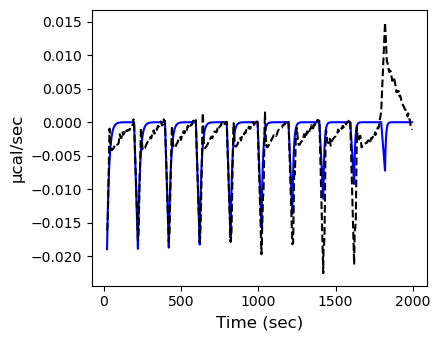

In [15]:
# Plot all fitted peaks
rows = 1
cols = 1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].index, 
           df_sim.loc[df_PRDX1.index]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.index, df_PRDX1["Rate μcal/sec"],"k--", label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,f"fit_koff_ITC_heat_vs_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_93008/3937970084.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


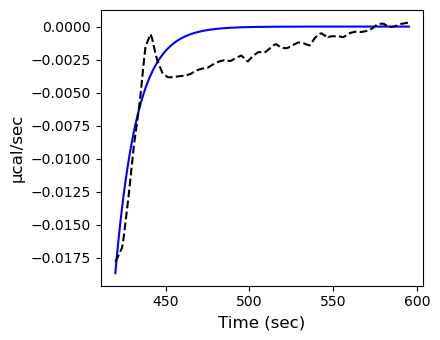

In [16]:
# Plot single peak
inject_num = 2
injection_interval = 200

start = inject_num*injection_interval
end = start + injection_interval

rows = 1
cols = 1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].loc[start: end].index, 
           df_sim.loc[df_PRDX1.index].loc[start: end]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.loc[start: end].index, 
           df_PRDX1.loc[start: end]["Rate μcal/sec"],
           "k--", 
           label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,f"fit_koff_ITC_heat_peak_vs_time.pdf"),dpi= mpl_dpi)
          

### Check fit data range dependancy

Check how koff and kon fit depends on the number of injections in fit data

In [17]:
# Create result df
num_injections = 10
rates_fit = np.zeros((num_injections,3))

# Fit on each injection range
for count in range(num_injections):
    injection = count+1
    
    # Set up lmfit parameter library object with each parameter to be fitted
    param_lib = Parameters()
    param_lib.add('koff',value=100.0,min=1e-12)
    param_lib.add('kon',value=100.0,min=1e-12,vary=False)
    param_lib.add('Kd_app', value = Kd_app_vil,vary=False, min = 1e-12)

    # Slice data for injection range
    df_PRDX1_sliced = df_PRDX1[df_PRDX1.index <= injection*inj_interval_PRDX1]
    
    # Perform fit
    fit_koff_kon = minimize(fit_koff_kon_res, 
                             param_lib, 
                             method=fitting_method,
                             args=(mod_ITC_Prx_dim_dec,
                                   mod_ITC_Prx_dim_dec.injection_enthalpy,
                                   df_PRDX1_sliced),
                             epsfcn=0.0001)
    
    # Store koff and kon
    rates_fit[count,0] = injection
    rates_fit[count,1] = fit_koff_kon.params["koff"].value
    rates_fit[count,2] = fit_koff_kon.params["kon"].value

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.465228880907812
Area: 28.18940091096043
Area: 27.374035154566666
Area: 25.76604609197798
Area: 23.404440715473182
Area: 20.646032339298444
Area: 17.91125190070154
Area: 15.463742262773838
Area: 13.390218763420792
Area: 11.675255601565867
Area: 10.265870623340176
Area: 9.104289348383869
Area: 8.139920435310584
Area: 7.331929409681843
Area: 6.648401086755788
Area: 6.064679961274808
Area: 5.561724941884329
Area: 5.1247501056462665
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.349374092015896
Area: 28.073529325882966
Area: 27.258188296773458
Area: 25.650373020100773
Area: 23.28920750526479
Area: 20.531541866855004
Area: 17.797761407234695
Area: 15.351440446213312
Area: 13.279233053500901
Area: 11.565666662407063
Area: 10.157721628291632
Area: 8.997598301419352
Area: 8.034694283563926
Area: 7.228161049545768
Area: 6.5460785790894995
Area: 5.963788772860188
Area: 5.462242256877319
Area: 5.026655758445107
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Cal

28.347524228822532
Area: 28.071678841252066
Area: 27.256339761075342
Area: 25.648528183801655
Area: 23.287370462732145
Area: 20.52971721775848
Area: 17.79595318917951
Area: 15.349651720574705
Area: 13.277465914760302
Area: 11.563922426322007
Area: 10.156000992553926
Area: 8.995900347177386
Area: 8.033021760092556
Area: 7.226512331480873
Area: 6.544453530109928
Area: 5.962187210062421
Area: 5.460663818065002
Area: 5.025100086462509
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.359542704376242
Area: 28.08369703616629
Area: 27.26834999651775
Area: 25.660514754588785
Area: 23.29930682796775
Area: 20.541573212185227
Area: 17.807702688726724
Area: 15.361274864960064
Area: 13.288949136340197
Area: 11.575257188853666
Area: 10.167182783878213
Area: 9.006926616953615
Area: 8.043891315854209
Area: 7.23722799222048
Area: 6.5550157878569575
Area: 5.97259726498509
Area: 5.470923936541126
Area: 5.0352126468421075
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.35905780845786
Area: 28.08321217915261
Area: 27.267865414812373
Area: 25.660031110175
Area: 23.298825198503327
Area: 20.541094808990042
Area: 17.807228570493418
Area: 15.360805831243251
Area: 13.288485732852289
Area: 11.57479976205389
Area: 10.166731516936299
Area: 9.006483184727854
Area: 8.043453448147144
Area: 7.236795473694728
Area: 6.554589442549395
Area: 5.972177042067325
Area: 5.4705097494313915
Area: 5.034804402215692
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.40790296580718
Area: 28.13205866167006
Area: 27.316691585124357
Area: 25.708769938291837
Area: 23.34736796777539
Area: 20.589317959873416
Area: 17.855024953223744
Area: 15.408095602149768
Area: 13.335214636744356
Area: 11.620933451964177
Area: 10.212251590474112
Area: 9.051380162730466
Area: 8.087726385263375
Area: 7.280447935306971
Area: 6.597625854714758
Area: 6.014603844627818
Area: 5.512335976464289
Area: 5.076039094876927
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.421003796086016
Area: 28.145161612831384
Area: 27.329791758366806
Area: 25.721850826158356
Area: 23.360399220753294
Area: 20.602265324013445
Area: 17.86785960960157
Area: 15.420796294959684
Area: 13.347767018792444
Area: 11.633328419346773
Area: 10.22448425854646
Area: 9.063449490304551
Area: 8.099630351451637
Area: 7.292187020250912
Area: 6.609201942018197
Area: 6.026018770058885
Area: 5.523592123994789
Area: 5.087138853674252
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.417183483218004
Area: 28.14134101433363
Area: 27.32597066390194
Area: 25.718036105921993
Area: 23.356598685254454
Area: 20.598489061932423
Area: 17.86411613670825
Area: 15.41709180381148
Area: 13.344105681677041
Area: 11.62971288104288
Area: 10.220915942238777
Area: 9.05992831999948
Area: 8.096157548030346
Area: 7.28876231817212
Area: 6.605824655029943
Area: 6.022688403799052
Area: 5.520307972027345
Area: 5.083900163239422
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.42816065393997
Area: 28.15232083148913
Area: 27.336948633518396
Area: 25.728998244804735
Area: 23.367520463044233
Area: 20.60934136454194
Area: 17.87487436801621
Area: 15.42773820735862
Area: 13.354628285095458
Area: 11.640104073389166
Area: 10.231171447244972
Area: 9.070047523210267
Area: 8.106138669961588
Area: 7.298606186292999
Area: 6.615532522661535
Area: 6.032261578577143
Area: 5.529748542593349
Area: 5.093210432632179
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.428026510639814
Area: 28.152186673688995
Area: 27.336814483215925
Area: 25.72886426546764
Area: 23.367386969386448
Area: 20.609208716054358
Area: 17.874742865458458
Area: 15.427608067736594
Area: 13.354499654599937
Area: 11.639977050755434
Area: 10.231046071356513
Area: 9.06992354300509
Area: 8.10601669934538
Area: 7.298485825273039
Area: 6.615413819760423
Area: 6.032144521233147
Area: 5.529633101951957
Area: 5.093096586424207
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is eval

28.465228880907812
Area: 28.18940091096043
Area: 27.374035154566666
Area: 25.76604609197798
Area: 23.404440715473182
Area: 20.646032339298444
Area: 17.91125190070154
Area: 15.463742262773838
Area: 13.390218763420792
Area: 11.675255601565867
Area: 10.265870623340176
Area: 9.104289348383869
Area: 8.139920435310584
Area: 7.331929409681843
Area: 6.648401086755788
Area: 6.064679961274808
Area: 5.561724941884329
Area: 5.1247501056462665
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.44648780513264
Area: 28.170652774985847
Area: 27.355280672268314
Area: 25.747309131732507
Area: 23.38576592306377
Area: 20.627472451438106
Area: 17.892849682884624
Area: 15.445528081362196
Area: 13.372212856704243
Area: 11.657470628198062
Area: 10.248313389539675
Area: 9.086962230784106
Area: 8.122825168357979
Area: 7.315065413325116
Area: 6.631766026477625
Area: 6.048271537682633
Area: 5.545538665630261
Area: 5.108783944811138
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.452353976406908
Area: 28.17652013631172
Area: 27.361150773272467
Area: 25.753172136518295
Area: 23.39160971170065
Area: 20.633279599892184
Area: 17.89860731057336
Area: 15.451226696773512
Area: 13.377846094047095
Area: 11.66303447809287
Area: 10.253805743803063
Area: 9.092382080100485
Area: 8.128171899458454
Area: 7.320340262688037
Area: 6.636969024519562
Area: 6.053403476972539
Area: 5.5506007049898045
Area: 5.113776895671324
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.450437833415318
Area: 28.174612323355245
Area: 27.359242525378612
Area: 25.751265622560823
Area: 23.389709561935945
Area: 20.631391169104145
Area: 17.896734964014605
Area: 15.449373520268159
Area: 13.376014157559293
Area: 11.66122508627971
Area: 10.252019582262792
Area: 9.090619672000324
Area: 8.126433477987087
Area: 7.318624761047963
Area: 6.635276866674607
Area: 6.051734396469225
Area: 5.548954326651529
Area: 5.112152981287045
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

28.461560766874044
Area: 28.185731774722605
Area: 27.370364527445354
Area: 25.762377955804464
Area: 23.400784167452066
Area: 20.642397988067213
Area: 17.907648266220843
Area: 15.460175288782962
Area: 13.386692420618893
Area: 11.671772333704427
Area: 10.2624317771222
Area: 9.100895360342193
Area: 8.136571688486296
Area: 7.3286258644654065
Area: 6.645142209907232
Area: 6.061465626448416
Area: 5.558553558953273
Area: 5.121621646717758
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol 

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol 

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol 

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_

28.47699152072802
Area: 28.201170654460693
Area: 27.385810234096237
Area: 25.777814010921123
Area: 23.41617232106664
Area: 20.657693058358493
Area: 17.922814571859483
Area: 15.47518779017479
Area: 13.401534429707276
Area: 11.686433629244686
Area: 10.276906953708435
Area: 9.115181974416
Area: 8.150668887529505
Area: 7.342532930131462
Area: 6.658861793783319
Area: 6.074999981640539
Area: 5.571906201498274
Area: 5.134794243357848
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.55148335573564
Area: 28.275748036643538
Area: 27.4605003664607
Area: 25.852561525255663
Area: 23.49076214354387
Area: 20.731872723700217
Area: 17.996390493979224
Area: 15.548035429390085
Area: 13.473574180306127
Area: 11.75761735163504
Area: 10.347207599501422
Area: 9.184584706687797
Area: 8.219172243657848
Area: 7.41014131616563
Area: 6.725582579930493
Area: 6.140846443969099
Area: 5.636888858687275
Area: 5.198925899081163
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

28.520752568799793
Area: 28.244970674731466
Area: 27.42966059027021
Area: 25.821670446010128
Area: 23.459918182913256
Area: 20.701188871441797
Area: 17.965951625923342
Area: 15.517894337444874
Area: 13.443763425928053
Area: 11.728156392393048
Area: 10.318107767550249
Area: 9.155851704872441
Area: 8.190806797925028
Area: 7.3821426419824485
Area: 6.6979469094787785
Area: 6.113568265455098
Area: 5.60996383320889
Area: 5.172349568542953
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Cal

28.533749350741523
Area: 28.257989752246935
Area: 27.44269806880606
Area: 25.83472220606351
Area: 23.472947195914365
Area: 20.714147895525656
Area: 17.978806372089295
Area: 15.53062270961313
Area: 13.456351609415261
Area: 11.740596242221967
Area: 10.33039435181406
Area: 9.167982656676221
Area: 8.202781755610866
Area: 7.393961875319337
Area: 6.7096121223161775
Area: 6.125081792322458
Area: 5.621327507598849
Area: 5.1835652837722
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.52816310545709
Area: 28.252393530879015
Area: 27.437090563021957
Area: 25.82911165244023
Area: 23.46734513370634
Area: 20.708575017485938
Area: 17.97327817728251
Area: 15.525148749190262
Area: 13.45093781531704
Area: 11.735246088316675
Area: 10.325109984068728
Area: 9.162765067012396
Area: 8.197631117065006
Area: 7.388878093117692
Area: 6.704594445131642
Area: 6.12012923546884
Area: 5.616439254154114
Area: 5.178740579361457
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

28.530561888569725
Area: 28.254794353296685
Area: 27.439501125068457
Area: 25.83152049659771
Area: 23.46975019490368
Area: 20.710967482119724
Area: 17.975651429638095
Area: 15.527498696515504
Area: 13.453261911375986
Area: 11.737542861258977
Area: 10.327378468809703
Area: 9.165007806451726
Area: 8.199845180156034
Area: 7.391060392088509
Area: 6.706748342195722
Area: 6.12225515738126
Area: 5.618537543849996
Area: 5.1808115670224275
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.529276235342937
Area: 28.253507586398317
Area: 27.438211792861534
Area: 25.830229374001924
Area: 23.468461074807824
Area: 20.70968510092885
Area: 17.974379340962177
Area: 15.52623909579584
Area: 13.45201616299789
Area: 11.736311740751733
Area: 10.326162519510966
Area: 9.163804275397318
Area: 8.198656975202782
Area: 7.389890626129644
Area: 6.7055937941259645
Area: 6.121115601227115
Area: 5.617412794415256
Area: 5.179701443610185
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.528399810111953
Area: 28.252624278951405
Area: 27.437321758305117
Area: 25.829343151948944
Area: 23.467576260919607
Area: 20.708804929680348
Area: 17.973506241281896
Area: 15.52537457231311
Area: 13.45116115271842
Area: 11.735466792201072
Area: 10.325327970419663
Area: 9.162983276552202
Area: 8.19784665430275
Area: 7.3890877957153505
Area: 6.704801416951693
Area: 6.120333518080993
Area: 5.616640879659873
Area: 5.178939575755455
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.528502871855505
Area: 28.252733562918777
Area: 27.43743125471707
Area: 25.829452793246237
Area: 23.467685726554386
Area: 20.708913820194386
Area: 17.9736142566074
Area: 15.525481526394154
Area: 13.45126692963487
Area: 11.73557132520584
Area: 10.32543121661916
Area: 9.163085384320151
Area: 8.197947456470036
Area: 7.389187115929914
Area: 6.7048994437328515
Area: 6.120430271005483
Area: 5.616736374243118
Area: 5.179033826994771
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.52842641662286
Area: 28.252650907991637
Area: 27.437348438958093
Area: 25.829369867836476
Area: 23.467602933960425
Area: 20.708831462566803
Area: 17.973532560904165
Area: 15.525400633340134
Area: 13.451186926901704
Area: 11.735492263847208
Area: 10.32535312837237
Area: 9.163005132532744
Area: 8.197868098551483
Area: 7.389111997120424
Area: 6.704825302596762
Area: 6.120357093437081
Area: 5.616664148372078
Area: 5.178962543240799
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.528400206292204
Area: 28.25263083213706
Area: 27.437328324311427
Area: 25.82934972658941
Area: 23.467582825012954
Area: 20.70881145928628
Area: 17.973512718409506
Area: 15.525380985803539
Area: 13.451167495623954
Area: 11.73547305993966
Area: 10.325334161323266
Area: 9.162986410827683
Area: 8.197849616093881
Area: 7.389093752116173
Area: 6.704807295195201
Area: 6.120339319658666
Area: 5.616646605935297
Area: 5.17894522970358
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.528395278715934
Area: 28.252625900410614
Area: 27.43732338297993
Area: 25.829344778726156
Area: 23.467577885099956
Area: 20.70880654532796
Area: 17.97350784394443
Area: 15.525376159230293
Area: 13.451162722172427
Area: 11.735468345289013
Area: 10.325329504838518
Area: 9.162984750367347
Area: 8.197848107188431
Area: 7.389089269353441
Area: 6.704802871386511
Area: 6.120334953627798
Area: 5.616642296491638
Area: 5.178940978252221
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.617314813048484
Area: 28.341779754659964
Area: 27.52682476118266
Area: 25.919192620388237
Area: 23.557470992122603
Area: 20.79831849976113
Area: 18.062338579612238
Area: 15.613357757026426
Area: 13.538199719894768
Area: 11.821504964457281
Area: 10.410332598489738
Area: 9.246937005241408
Area: 8.280748909070732
Area: 7.470944770029098
Area: 6.7856208634387905
Area: 6.200128589286168
Area: 5.695425634956033
Area: 5.256729594906741
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

28.571689655083294
Area: 28.29598986794519
Area: 27.4808109127346
Area: 25.87292433982367
Area: 23.511118942706986
Area: 20.75213509727682
Area: 18.0164955474135
Area: 15.567946791437977
Area: 13.493270366089032
Area: 11.777085610919112
Area: 10.366440584156157
Area: 9.203580134594358
Area: 8.237928165961089
Area: 7.428657370080941
Area: 6.7438622311205325
Area: 6.158892884579211
Area: 5.654705201539699
Area: 5.2165159067473965
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.590652069794224
Area: 28.315004972191357
Area: 27.499901026281076
Area: 25.89209739949214
Area: 23.53030700839506
Area: 20.77124560655929
Area: 18.03546191095107
Area: 15.58673259633066
Area: 13.511855388655976
Area: 11.795458132127429
Area: 10.384593247304856
Area: 9.221508563461821
Area: 8.255633203699713
Area: 7.446141218133271
Area: 6.761125634848381
Area: 6.175938218752404
Area: 5.671535922216223
Area: 5.2331356492423255
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

28.582738495064678
Area: 28.30707250054628
Area: 27.491930520925166
Area: 25.884097418399577
Area: 23.522296118657298
Area: 20.763264975183237
Area: 18.02754073667545
Area: 15.578886496797335
Area: 13.504092896120685
Area: 11.787784119662756
Area: 10.377010907260399
Area: 9.214019890566279
Area: 8.248237504171446
Area: 7.438837206406145
Area: 6.753913414303593
Area: 6.168816927868798
Area: 5.664503871444262
Area: 5.22619147256274
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.586065913920603
Area: 28.31041653004087
Area: 27.495290223863616
Area: 25.887462536000925
Area: 23.5256652698492
Area: 20.76662112695521
Area: 18.03087178039319
Area: 15.58218591869381
Area: 13.507357114077466
Area: 11.791011081913007
Area: 10.380199151023831
Area: 9.21716824013147
Area: 8.25134674385152
Area: 7.441908379504364
Area: 6.756945940797977
Area: 6.171811043630356
Area: 5.6674605312186355
Area: 5.229111131820324
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

28.574700749977122
Area: 28.299021206323957
Area: 27.48384499426977
Area: 25.875970397824855
Area: 23.51416642684093
Area: 20.755169728113103
Area: 18.019507051803814
Area: 15.570929489664628
Area: 13.496221039101286
Area: 11.780002395781166
Area: 10.369322341579585
Area: 9.206424962499208
Area: 8.240737411196742
Area: 7.431432431644726
Area: 6.746602111939106
Area: 6.161598034315644
Area: 5.65737608883896
Area: 5.219153177632472
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.58406291074412
Area: 28.308403402670905
Area: 27.49326773139805
Area: 25.885430091460492
Area: 23.52363029549674
Area: 20.764593958366518
Area: 18.028859759815127
Area: 15.580192989234689
Area: 13.505385440286663
Area: 11.789061898412193
Area: 10.378273429712078
Area: 9.215265928817407
Area: 8.24946808035688
Area: 7.440053268081155
Area: 6.755114163316785
Area: 6.170002541501299
Area: 5.665674562630295
Area: 5.227347505419362
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

28.58389181697907
Area: 28.308221438935075
Area: 27.49309554441251
Area: 25.885257073521053
Area: 23.52345707542635
Area: 20.764421409213547
Area: 18.028688502564528
Area: 15.580023358209772
Area: 13.505217619716483
Area: 11.788895993632222
Area: 10.378109505275384
Area: 9.215105010298235
Area: 8.249309116631983
Area: 7.439895374536384
Area: 6.7549582574249625
Area: 6.169848599788761
Area: 5.665522558019214
Area: 5.227197402440306
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.583853501032106
Area: 28.30818950450493
Area: 27.49306346377343
Area: 25.88522483841897
Area: 23.52342480292422
Area: 20.764389261820057
Area: 18.028656595902724
Area: 15.579991754537552
Area: 13.505186353368774
Area: 11.788865085922511
Area: 10.378078966357158
Area: 9.215073845528652
Area: 8.249278383021153
Area: 7.439865958047782
Area: 6.754929210981697
Area: 6.169819919230636
Area: 5.665494238456289
Area: 5.227169434673336
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

28.58385334725216
Area: 28.30818289987033
Area: 27.493056829181022
Area: 25.88521817187084
Area: 23.523418128603755
Area: 20.764382613383553
Area: 18.028649997257922
Area: 15.579985218570615
Area: 13.505179887172668
Area: 11.788858698279498
Area: 10.37807265416066
Area: 9.215067610345754
Area: 8.249272229256528
Area: 7.439859874382569
Area: 6.754923203930469
Area: 6.169813987968179
Area: 5.6654883817300306
Area: 5.227163659266349
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.69549619050176
Area: 28.42059664105475
Area: 27.606577973270145
Area: 26.00015566386405
Area: 23.63919368709741
Area: 20.88007138537282
Area: 18.14360416856721
Area: 15.693901243746456
Area: 13.617921012255355
Area: 11.90035044498714
Area: 10.488276302810082
Area: 9.323968213259525
Area: 8.356863645371876
Area: 7.546147515572847
Area: 6.859919961976302
Area: 6.273534510305643
Area: 5.767948614116697
Area: 5.328383478194377
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin

28.646113136746248
Area: 28.37073432515345
Area: 27.556029811957345
Area: 25.94868741343853
Area: 23.58710716155412
Area: 20.827902158446076
Area: 18.09172318713639
Area: 15.64247369032491
Area: 13.567013400280423
Area: 11.849997643127576
Area: 10.438494733798297
Area: 9.274763284543614
Area: 8.308238897405577
Area: 7.498100231599006
Area: 6.812444948916734
Area: 6.226624878878948
Area: 5.721597804881016
Area: 5.282583221866168
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.6667979671087
Area: 28.39158469027933
Area: 27.577116320249814
Area: 25.970079584349172
Area: 23.608694347724853
Area: 20.84948560538743
Area: 18.11317626731019
Area: 15.663735421305756
Area: 13.588057985686774
Area: 11.870810880394295
Area: 10.459069379444841
Area: 9.29509735954492
Area: 8.32833100807193
Area: 7.517951600921183
Area: 6.832057734361337
Area: 6.24600171143563
Area: 5.740741557099891
Area: 5.3014975546277965
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin

28.65836441644164
Area: 28.383068205514515
Area: 27.56849755743546
Area: 25.961326003046175
Area: 23.599852298528667
Area: 20.84064073190481
Area: 18.10438458360345
Area: 15.655021393245422
Area: 13.57943260649767
Area: 11.862280026947747
Area: 10.450635759644443
Area: 9.286762116007928
Area: 8.320094501877067
Area: 7.509813432511528
Area: 6.824017013526077
Area: 6.238057331274317
Area: 5.732892346326774
Area: 5.293742035310905
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.661869887031227
Area: 28.386597419902667
Area: 27.57207211726575
Area: 25.964958032618064
Area: 23.603521987914203
Area: 20.844315726598573
Area: 18.108035755108887
Area: 15.658640212041954
Area: 13.583014549971793
Area: 11.865822658930933
Area: 10.454137953745402
Area: 9.29022340532239
Area: 8.323514678195869
Area: 7.513192728953531
Area: 6.827355786236468
Area: 6.241356043210516
Area: 5.736151470491622
Area: 5.29696219214484
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.661392081519562
Area: 28.38611730277349
Area: 27.57158570556336
Area: 25.964463625769994
Area: 23.603022307267032
Area: 20.843815573650836
Area: 18.107538492595754
Area: 15.658147347172465
Area: 13.582526702260708
Area: 11.865340161496027
Area: 10.453660959927895
Area: 9.28975197542978
Area: 8.323048841213984
Area: 7.5127324536341575
Area: 6.826901026911729
Area: 6.240906734913139
Area: 5.735707549215032
Area: 5.296523570009996
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.651665660863035
Area: 28.376309858292444
Area: 27.56166703333415
Area: 25.95440146865417
Area: 23.592868895801484
Area: 20.833662442755106
Area: 18.097447770409524
Area: 15.648146856664862
Area: 13.57262834920255
Area: 11.855550562713276
Area: 10.4439838071399
Area: 9.2801875140407
Area: 8.313598357068926
Area: 7.503395334771261
Area: 6.817676110407664
Area: 6.2317927997379945
Area: 5.726703235120678
Area: 5.287627175362876
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

28.66015540512691
Area: 28.38486767184989
Area: 27.57031987829546
Area: 25.963177252274157
Area: 23.60172243167758
Area: 20.842512182130353
Area: 18.106245062066037
Area: 15.656865366661519
Area: 13.581257779123343
Area: 11.864085161020684
Area: 10.452420280902018
Area: 9.288525776552245
Area: 8.321837204231876
Area: 7.511535288890846
Area: 6.825718214870293
Area: 6.2397381094111735
Area: 5.734552941910006
Area: 5.295382762332378
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.659824771921603
Area: 28.384542410242044
Area: 27.56999044526881
Area: 25.962842533204
Area: 23.601384250755245
Area: 20.84217373823464
Area: 18.105908593844
Area: 15.656531880361987
Area: 13.580927691273747
Area: 11.863758695791313
Area: 10.452097542324648
Area: 9.28820666605125
Area: 8.321521991581632
Area: 7.511223877624931
Area: 6.825410537884334
Area: 6.239434124171064
Area: 5.734252605228764
Area: 5.295086017600133
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating 

28.65977845178828
Area: 28.384488917653307
Area: 27.56993626841456
Area: 25.962787489547186
Area: 23.601328639869763
Area: 20.84211808513442
Area: 18.105853265987378
Area: 15.65647704304334
Area: 13.580873412870478
Area: 11.863705012892112
Area: 10.452044471944475
Area: 9.288154361050035
Area: 8.321470196756776
Area: 7.5111726705879995
Area: 6.825359945014588
Area: 6.2393841383654705
Area: 5.734203219491427
Area: 5.295037221772922
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.659767664377814
Area: 28.38447807869307
Area: 27.569925290892257
Area: 25.962776336632203
Area: 23.601317371993265
Area: 20.84210680876175
Area: 18.10584205553017
Area: 15.656465931979817
Area: 13.580862415050023
Area: 11.863694135640696
Area: 10.45203371862114
Area: 9.288143588236816
Area: 8.321459663179306
Area: 7.5111622951296235
Area: 6.825349693963401
Area: 6.239374010380066
Area: 5.734193213007594
Area: 5.295027336442346
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.65976477929847
Area: 28.38447518019266
Area: 27.569922355047034
Area: 25.962773353877864
Area: 23.601314358418243
Area: 20.842103792927652
Area: 18.105839057323806
Area: 15.65646296035786
Area: 13.580859473717595
Area: 11.863691226781972
Area: 10.452030843342097
Area: 9.288140889462744
Area: 8.321456888343796
Area: 7.5111595202174035
Area: 6.82534695235683
Area: 6.23937130161511
Area: 5.7341905368689154
Area: 5.295024690966071
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.465228880907812
Area: 28.18940091096043
Area: 27.374035154566666
Area: 25.76604609197798
Area: 23.404440715473182
Area: 20.646032339298444
Area: 17.91125190070154
Area: 15.463742262773838
Area: 13.390218763420792
Area: 11.675255601565867
Area: 10.265870623340176
Area: 9.104289348383869
Area: 8.139920435310584
Area: 7.331929409681843
Area: 6.648401086755788
Area: 6.064679961274808
Area: 5.561724941884329
Area: 5.1247501056462665
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.774171622636814
Area: 28.501512574802163
Area: 27.690554809673078
Area: 26.08821756775116
Area: 23.730653258513193
Area: 20.97297418803663
Area: 18.236470852029075
Area: 15.786097277544101
Area: 13.709239898327722
Area: 11.990721244501904
Area: 10.577667844070152
Area: 9.41236381023756
Area: 8.44426327983479
Area: 7.632555981473999
Area: 6.9453437886289215
Area: 6.357986085490633
Area: 5.851444095752635
Area: 5.4109335350767465
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.737260297339247
Area: 28.4631764133966
Area: 27.650354406428104
Area: 26.045402452083742
Area: 23.68563347639411
Area: 20.926914074504232
Area: 18.190316899536107
Area: 15.74024353176607
Area: 13.663811016422093
Area: 11.945756992121618
Area: 10.533184156969721
Area: 9.36836865760126
Area: 8.400756392919105
Area: 7.589535064136449
Area: 6.902805473210207
Area: 6.315924496491285
Area: 5.809851373968294
Area: 5.369804014303337
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d

28.746559044731622
Area: 28.47277107221298
Area: 27.66026814661131
Area: 26.055883857006485
Area: 23.69647078225842
Area: 20.937931013118416
Area: 18.20133229981211
Area: 15.751179134414375
Area: 13.674642460314889
Area: 11.956476988494087
Area: 10.54378837094048
Area: 9.378854811080155
Area: 8.41112485881585
Area: 7.599786364295467
Area: 6.9129403144105925
Area: 6.325944557631021
Area: 5.819758412754302
Area: 5.379598805494878
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.754577055727218
Area: 28.481017702503035
Area: 27.668910622962752
Area: 26.06504103925258
Area: 23.70604072473933
Area: 20.947692196988616
Area: 18.21110159713087
Area: 15.760883079013592
Area: 13.684255563114476
Area: 11.965991373822263
Area: 10.553200625374483
Area: 9.388163141885807
Area: 8.4203293408693
Area: 7.608887641551208
Area: 6.921939013802321
Area: 6.334841968230304
Area: 5.8285560834692225
Area: 5.388297346983771
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

28.753346025650778
Area: 28.479764126160624
Area: 27.667593978313278
Area: 26.063566262194232
Area: 23.704560568356264
Area: 20.94617708034183
Area: 18.209582903383723
Area: 15.759374281406343
Area: 13.682760813282831
Area: 11.964511949942533
Area: 10.551737042587998
Area: 9.386715664945024
Area: 8.418897960569959
Area: 7.6074722753146675
Area: 6.920539564582896
Area: 6.333458214372132
Area: 5.82718780676142
Area: 5.386944422531551
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

28.753701233152036
Area: 28.480125791987692
Area: 27.66797370019087
Area: 26.06404073347809
Area: 23.704987067557024
Area: 20.94661355796913
Area: 18.210020374651045
Area: 15.759808891614956
Area: 13.683191374169736
Area: 11.964938095038791
Area: 10.552158623106273
Area: 9.387132605589521
Area: 8.419310266521341
Area: 7.607879961857444
Area: 6.920942664876873
Area: 6.333856791670975
Area: 5.827581924335945
Area: 5.38733411447139
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

28.753396375766684
Area: 28.479815773027774
Area: 27.66764819595608
Area: 26.063624098528006
Area: 23.70462144704634
Area: 20.946239378305794
Area: 18.209645341345755
Area: 15.759436310503036
Area: 13.682822264319991
Area: 11.964572770716206
Area: 10.55179721170711
Area: 9.386775172152346
Area: 8.41895680673321
Area: 7.607530461302801
Area: 6.920597095943471
Area: 6.333515100083113
Area: 5.827244055850578
Area: 5.387000025543172
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

28.753355200936177
Area: 28.479773469013246
Area: 27.667603785066543
Area: 26.06357672276451
Area: 23.70457157915121
Area: 20.946188347823604
Area: 18.20959419613295
Area: 15.759385500213215
Area: 13.682771927533183
Area: 11.964522950176526
Area: 10.55174792499368
Area: 9.386726427926684
Area: 8.418908604443047
Area: 7.6074827990228
Area: 6.920549969877115
Area: 6.333468502891631
Area: 5.8271979801047795
Area: 5.386954476296444
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.753347369236188
Area: 28.479765879138682
Area: 27.667595816476087
Area: 26.063568222954235
Area: 23.704562632237145
Area: 20.946179192324646
Area: 18.209585020108715
Area: 15.759376384266329
Area: 13.682762896539797
Area: 11.96451401183116
Area: 10.551739082382358
Area: 9.38671768419443
Area: 8.418899960062506
Area: 7.6074742478912825
Area: 6.920541514957182
Area: 6.333460142869063
Area: 5.8271897136774795
Area: 5.386946295059006
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Cal

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d

28.80838781904385
Area: 28.538933595156358
Area: 27.73198975775656
Area: 26.1356447755857
Area: 23.78327038582085
Area: 21.028398835309478
Area: 18.2926810187013
Area: 15.842138154397658
Area: 13.764814721885273
Area: 12.045749763376048
Area: 10.632127426669703
Area: 9.466247551425155
Area: 8.497568470893004
Area: 7.685285167764695
Area: 6.997503247428285
Area: 6.409582090602852
Area: 5.902481877606644
Area: 5.4614243751247455
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d

28.797747988868124
Area: 28.526842856379197
Area: 27.71821538495757
Area: 26.11923869805003
Area: 23.764422660730407
Area: 21.00827613319445
Area: 18.272152750402295
Area: 15.821633827647114
Area: 13.744472364558403
Area: 12.025603805753086
Area: 10.61218726548319
Area: 9.446515383176886
Area: 8.478045753088484
Area: 7.665971052320211
Area: 6.978395005437489
Area: 6.3906780257695806
Area: 5.883780024715544
Area: 5.44291919323003
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.796119857228117
Area: 28.52513598052212
Area: 27.71611954448847
Area: 26.11686013386295
Area: 23.761859388039145
Area: 21.00554548011167
Area: 18.269372891585284
Area: 15.81885984932456
Area: 13.741720972376529
Area: 12.022879301136271
Area: 10.609490824622169
Area: 9.443847319035426
Area: 8.475406207942834
Area: 7.663359957200192
Area: 6.975811953495786
Area: 6.388122782513006
Area: 5.88

28.80042470083588
Area: 28.52989812731372
Area: 27.72161056540411
Area: 26.123170717481365
Area: 23.76884556939408
Area: 21.012920569452557
Area: 18.276895095348646
Area: 15.826361370916072
Area: 13.749161943050597
Area: 12.03024769503023
Area: 10.616783504468003
Area: 9.451063347681172
Area: 8.482545264093751
Area: 7.670422262504252
Area: 6.982798457702637
Area: 6.3950341945617994
Area: 5.888089325286061
Area: 5.4471830053414765
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.800033708003074
Area: 28.52948576355581
Area: 27.721137474802806
Area: 26.122480553428186
Area: 23.76820053198572
Area: 21.012229222430214
Area: 18.276182678059055
Area: 15.825656872736507
Area: 13.748463058529092
Area: 12.029555605298729
Area: 10.616098504961503
Area: 9.450385524005142
Area: 8.481874662455112
Area: 7.669758858142186
Area: 6.982142146676176
Area: 6.3943849258832195
Area: 5.887447026613538
Area: 5.446547457982913
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

28.79997273156245
Area: 28.529183285266335
Area: 27.721063365971865
Area: 26.12239240220129
Area: 23.768099583827393
Area: 21.012121077029434
Area: 18.27607233932253
Area: 15.825546695450967
Area: 13.7483537605815
Area: 12.029447370444917
Area: 10.615991379233918
Area: 9.450279521127264
Area: 8.481769787297555
Area: 7.669655110724366
Area: 6.982039508970708
Area: 6.394283389438052
Area: 5.887346580751894
Area: 5.446448067312523
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

28.799963566716926
Area: 28.5291736269275
Area: 27.721052297997872
Area: 26.1223792501103
Area: 23.76808452489496
Area: 21.01210494559358
Area: 18.276055881194157
Area: 15.825530261533835
Area: 13.748337457839895
Area: 12.029431226221094
Area: 10.61597540046347
Area: 9.450263709614642
Area: 8.481754148031879
Area: 7.669639635971679
Area: 6.982024199708076
Area: 6.394268244398939
Area: 5.8873315986704124
Area: 5.446433241825606
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.437701446167345
Area: 28.161862844136827
Area: 27.346491906230224
Area: 25.738529733573195
Area: 23.377016912454053
Area: 20.61877799681093
Area: 17.884229711848107
Area: 15.436996829404787
Area: 13.363779809231223
Area: 11.64914187503241
Area: 10.240092078714113
Area: 9.078849528452762
Area: 8.114821810367786
Area: 7.3071706499674045
Area: 6.62397933589663
Area: 6.040591783531761
Area: 5.537964041862552
Area: 5.101313020788989
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.46143927714375
Area: 28.185610252512276
Area: 27.370242959471895
Area: 25.762256475009412
Area: 23.400663074081123
Area: 20.642277631703024
Area: 17.90752892835223
Area: 15.46005716631835
Area: 13.38657564482495
Area: 11.671656992201308
Area: 10.262317913427653
Area: 9.100782120250242
Area: 8.136459771240933
Area: 7.328516474255761
Area: 6.6450342999839505
Area: 6.061359178041114
Area: 5.558448549599401
Area: 5.121518044394678
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.446464658158543
Area: 28.1706296236216
Area: 27.355257517203608
Area: 25.747285999684703
Area: 23.385742869782703
Area: 20.62744954118869
Area: 17.89282696835854
Area: 15.445505600022967
Area: 13.372190633663354
Area: 11.65744868752079
Area: 10.248291734318533
Area: 9.086940540827445
Area: 8.122803514140488
Area: 7.315044604899912
Area: 6.631745501822333
Area: 6.048251295253717
Area: 5.545518699487048
Area: 5.108764245481952
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol 

28.451924860138252
Area: 28.176090927092286
Area: 27.360721461811067
Area: 25.75274320946773
Area: 23.39118221214039
Area: 20.632854734450447
Area: 17.898186062051423
Area: 15.450809759488617
Area: 13.377433933781312
Area: 11.662627395292274
Area: 10.253403892985965
Area: 9.09198584091971
Area: 8.127781316103011
Area: 7.319954286831686
Area: 6.636588299214795
Area: 6.053027943539944
Area: 5.55023027675758
Area: 5.113411528056462
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

28.452434695182774
Area: 28.1766008727128
Area: 27.36123152914571
Area: 25.75325282047532
Area: 23.391690127419324
Area: 20.633359520268527
Area: 17.89868655068659
Area: 15.451305126014311
Area: 13.377923624822932
Area: 11.663111060216718
Area: 10.253881344371404
Area: 9.092456437977397
Area: 8.12824538136468
Area: 7.32041286711135
Area: 6.637040641615722
Area: 6.053474119108559
Area: 5.550670386690701
Area: 5.113845637187616
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin

28.45197584399181
Area: 28.176141921976992
Area: 27.360772468667005
Area: 25.75279417048365
Area: 23.391233003420204
Area: 20.632905212698805
Area: 17.898236110519523
Area: 15.450859295698304
Area: 13.377482902372133
Area: 11.662675755266942
Area: 10.253451625188884
Area: 9.092032381538694
Area: 8.127827006322004
Area: 7.320000145523497
Area: 6.636633533699801
Area: 6.053072560002666
Area: 5.55027428670427
Area: 5.113454940127498
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.451924860138252
Area: 28.176090927092286
Area: 27.360721461811067
Area: 25.75274320946773
Area: 23.39118221214039
Area: 20.632854734450447
Area: 17.898186062051423
Area: 15.450809759488617
Area: 13.377433933781312
Area: 11.662627395292274
Area: 10.253403892985965
Area: 9.09198584091971
Area: 8.127781316103011
Area: 7.319954286831686
Area: 6.636588299214795
Area: 6.053027943539944
Area: 5.55023027675758
Area: 5.113411528056462


/tmp/ipykernel_93008/555108672.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


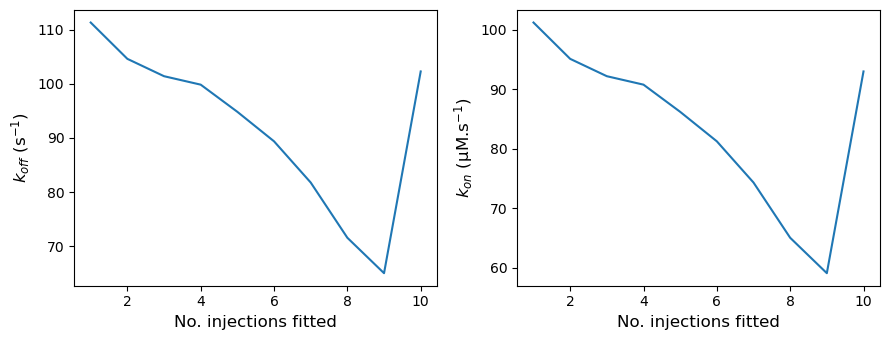

In [18]:
# Plot results
rows = 1
cols = 2

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

ax = axarr.flat[0]
ax.plot(rates_fit[:,0], rates_fit[:,1])
ax.set_xlabel(f'No. injections fitted',fontsize = mpl_xlabel_fontsize)
ax.set_ylabel(f'$k_{{off}}$ (s$^{{-1}}$)',fontsize = mpl_ylabel_fontsize)

ax = axarr.flat[1]
ax.plot(rates_fit[:,0], rates_fit[:,2])
ax.set_xlabel(f'No. injections fitted',fontsize = mpl_xlabel_fontsize)
ax.set_ylabel(f'$k_{{on}}$ ({mu}M.s$^{{-1}}$)',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()


## Fit Kd, koff and kon (not in paper)

In [19]:
# Load model
mod_ITC_Prx_dim_dec = load_ITC_model(df_ITC_PRDX1_inject_params)
Kd_app = 1.1 # Villar
PRDX1_enthalpy = mod_ITC_Prx_dim_dec.injection_enthalpy

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Kd_app" has been initialised but does not occur in a rate equation
Info: "injection_volume" has been initialised but does not occur in a rate equation
Info: "injection_dimer" has been initialised but does not occur in a rate equation
Info: "injection_decamer" has been initialised but does not occur in a rate equation
Info: "injection_interval" has been initialised but does not occur in a rate equation
Info: "first_inject_ratio" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conserv

In [20]:
# Set up lmfit parameter library object with each parameter to be fitted
param_lib = Parameters()
param_lib.add('koff',value=500.0,min=1e-12)
param_lib.add('kon',value=500.0,min=1e-12,vary=False)
param_lib.add('Kd_app', value = Kd_app_vil, min = 1e-12)

# Perform fit
fit_Kd_koff_kon = minimize(fit_koff_kon_res, 
                         param_lib, 
                         method=fitting_method,
                         args=(mod_ITC_Prx_dim_dec,
                               mod_ITC_Prx_dim_dec.injection_enthalpy,
                               df_PRDX1),
                         epsfcn=0.0001)

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 0.8
decamers: 10.040000000000001

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

e


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
24.99224319693975
Area: 24.99224307810761
Area: 24.992243186079296
Area: 24.99224305269467
Area: 24.99224305731509
Area: 24.992243037150196
Area: 24.992243042857936
Area: 24.99224303668649
Are


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
24.944900602095633
Area: 24.94490046859817
Area: 24.944900588640696
Area: 24.944900463767425
Area: 24.944900468104137
Area: 24.94490044737961
Area: 24.94490045326434
Area: 24.94490044725084
Area: 24.944900444557426
Area: 24.944900619933406
Area: 24.944900581154464
Area: 24.944900554804036
Area: 24.9449005540191
Area: 24.94488166998012
Area: 24.86914691888159
Area: 13.918365965881234
Area: 0.7373680000382288
Area: 0.03695846781091499
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec

14.98283527043454
Area: 14.98283513640802
Area: 14.982835307921622
Area: 14.982835153262336
Area: 14.982835164926591
Area: 14.982835112336877
Area: 14.982835130765691
Area: 14.982835164331426
Area: 14.982835161334535
Area: 14.982835303554625
Area: 14.982835271566538
Area: 14.982835241091326
Area: 14.982835240154822
Area: 14.982835248886273
Area: 14.982835275238356
Area: 14.982835258618078
Area: 14.982835266623203
Area: 14.982829324976214
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation


Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 0.8
decamers: 10.040000000000001

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

e


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
27.03746374028639
Area: 27.03746354805615
Area: 27.037463686383763
Area: 27.037463607833484
Area: 27.03746362331699
Area: 27.03746358758846
Area: 27.03746355020389
Area: 27.037463512271035
Area: 27.03746351713587
Area: 27.03746373325215
Area: 27.037463728684084
Area: 27.037463692012007
Area: 27.0374636821836
Area: 27.03746367403878
Area: 27.037463710445977
Area: 27.037463721933044
Area: 27.0

27.526188037318374
Area: 27.52618787420338
Area: 27.52618802020649
Area: 27.526187901889816
Area: 27.52618787033648
Area: 27.52618786387904
Area: 27.526187859780915
Area: 27.526187857066503
Area: 27.52618785516698
Area: 27.526188075240512
Area: 27.526188041211892
Area: 27.52618799820418
Area: 27.526188010024356
Area: 27.526188023570985
Area: 27.526188048437735
Area: 27.526188049952275
Area: 27.526187986655295
Area: 27.526123418703428
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 0.8
decamers: 10.040000000000001

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning a

28.156034649190435
Area: 28.15603449100685
Area: 28.1560346210633
Area: 28.156034494963595
Area: 28.156034501610478
Area: 28.156034495647386
Area: 28.15603449176516
Area: 28.156034489101273
Area: 28.15603448719248
Area: 28.1560346784342
Area: 28.15603466741575
Area: 28.15603463896084
Area: 28.156034646686017
Area: 28.156034663075094
Area: 28.156034679445764
Area: 28.156034685771395
Area: 28.156034629487454
Area: 28.155970086772708
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.00025855916468
Area: 28.00025840064542
Area: 28.00025853828879
Area: 28.0002583999076
Area: 28.00025839835016
Area: 28.000258392575766
Area: 28.00025838881859
Area: 28.00025838624536
Area: 

28.00025855916468
Area: 28.00025840064542
Area: 28.00025853828879
Area: 28.0002583999076
Area: 28.00025839835016
Area: 28.000258392575766
Area: 28.00025838881859
Area: 28.00025838624536
Area: 28.00025838441287
Area: 28.00025858138659
Area: 28.000258548761455
Area: 28.000258506694045
Area: 28.00025851725333
Area: 28.000258487084942
Area: 28.000258430797437
Area: 28.000258483553772
Area: 28.000258537118828
Area: 28.000193395020457
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.052218142703023
Area: 28.052217982520528
Area: 28.052218100372485
Area: 28.052217976371807
Area: 28.052217988849048
Area: 28.052217983275394
Area: 28.052217979636914
Area: 28.052217977119422
Area: 28.05221797533206
Area: 28.052218167717736
Area: 28.052218132436582
Area: 28.0522180860573
Area: 28.052218092638764
Area: 28.05221807296826
Area: 28.052218065848677
Area: 28.052218106667397
Area: 28.052218109601423
Area: 28.05215360953614
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-d


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (d


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.04185638313146
Area: 28.041856221059366
Area: 28.041856346893464
Area: 28.04185621759936
Area: 28.041856226487905
Area: 28.041856220884696
Area: 28.041856217231967
Area: 28.041856214699475
Area: 28.041856212921584
Area: 28.041856406568666
Area: 28.041856370586185
Area: 28.04185632621289
Area: 28.041856332851832
Area: 28.041856308160952
Area: 28.041856287850482
Area: 28.04185633521922
Area: 28.041856349752585
Area: 28.04179120838248
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Paper

28.054081708566894
Area: 28.05408154844212
Area: 28.054081665914147
Area: 28.054081542140015
Area: 28.054081554908475
Area: 28.05408154934579
Area: 28.054081545692554
Area: 28.054081543191074
Area: 28.054081541397753
Area: 28.0540817336468
Area: 28.054081698504117
Area: 28.05408165207685
Area: 28.054081658671603
Area: 28.054081640120703
Area: 28.054081634946858
Area: 28.054081674744527
Area: 28.054081675489254
Area: 28.054017174691147
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
C

28.04796859232125
Area: 28.04796843201971
Area: 28.04796855085729
Area: 28.04796842625916
Area: 28.047968436390217
Area: 28.047968430799823
Area: 28.047968427140987
Area: 28.047968424618393
Area: 28.04796842283091
Area: 28.047968615746036
Area: 28.047968580033455
Area: 28.047968535463138
Area: 28.04796854209449
Area: 28.04796852011082
Area: 28.04796850842429
Area: 28.047968551419107
Area: 28.047968559154416
Area: 28.047904060560167
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.04796859232125
Area: 28.04796843201971
Area: 28.04796855085729
Area: 28.04796842625916
Area: 28.047968436390217
Area: 28.047968430799823
Area: 28.047968427140987
Area: 28.047968424618393
Area: 28.04796842283091
Area: 28.047968615746036
Area: 28.047968580033455
Area: 28.047968535463138
Area: 28.04796854209449
Area: 28.0479685201108
Area: 28.047968508424017
Area: 28.047968551418915
Area: 28.047968558522232
Area: 28.04790340578505
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.p


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.04975942548169
Area: 28.049759265181653
Area: 28.04975938360934
Area: 28.049759259285672
Area: 28.049759269757754
Area: 28.04975926416974
Area: 28.04975926052115
Area: 28.049759258021737
Area: 28.049759256239486
Area: 28.049759448905764
Area: 28.049759415012034
Area: 28.04975936868568
Area: 28.049759375276967
Area: 28.049759354223365
Area: 28.049759344471596
Area: 28.04975938659503
Area: 28.049759392330035
Area: 28.04969489307575
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers 


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.048222564264602
Area: 28.048222403960544
Area: 28.04822252273736
Area: 28.04822239817652
Area: 28.048222408362008
Area: 28.04822240277407
Area: 28.04822239910371
Area: 28.048222396588404
Area: 28.0482223947927
Area: 28.048222587700888
Area: 28.048222551972714
Area: 28.04822250743911
Area: 28.048222514025547
Area: 28.048222492197674
Area: 28.048222480779295
Area: 28.048222523635232
Area: 28.04822253113303
Area: 28.048158032407283
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 0.8
decamers: 10.040000000000001

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

e


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0

In [21]:
# Display fit report
fit_Kd_koff_kon 

In [22]:
# Simulate ITC with fitted parameters
df_sim = do_ITC_assay(mod_ITC_Prx_dim_dec,PRDX1_enthalpy)
residuals = (df_PRDX1["Rate μcal/sec"].values - df_sim.loc[df_PRDX1.index]["Rate μcal/sec"].values)**2


event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is 

/tmp/ipykernel_93008/4211425661.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


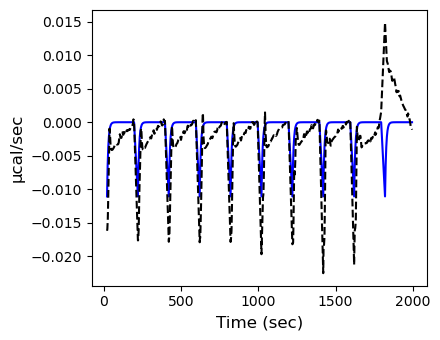

In [23]:
# Plot all fitted peaks
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].index, 
           df_sim.loc[df_PRDX1.index]["Rate μcal/sec"],
           "b-", 
           label="mod sim")
axarr.plot(df_PRDX1.index, 
           df_PRDX1["Rate μcal/sec"],
           "k--", 
           label="exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()


/tmp/ipykernel_93008/1582831180.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


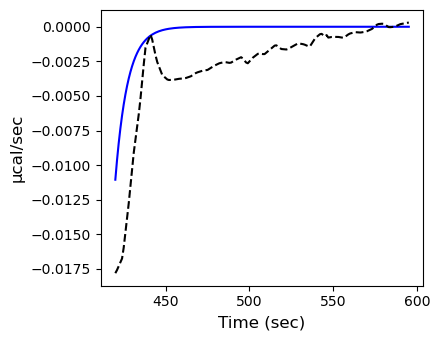

In [24]:
inject_num = 2
injection_interval = 200

start = inject_num*injection_interval
end = start + injection_interval

rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].loc[start: end].index, 
           df_sim.loc[df_PRDX1.index].loc[start: end]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.loc[start: end].index, df_PRDX1.loc[start: end]["Rate μcal/sec"],"k--", label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)


f.tight_layout()
f.show()


### Identifyability

We perform identifyability analysis on the fitted Kd and koff.

In [25]:
# Save the current session for loading into script
filename = 'session_identi_koff_Kdapp_PRDX1.pkl'
pickle.dump_session(filename)

# The script that will run
script_identi_koff_Kdapp_PRDX1 = """
import dill as pickle
filename = 'session_identi_koff_Kdapp_PRDX1.pkl'
pickle.load_session(filename)

identi_koff_Kdapp = conf_interval(koff_Kdapp_Minimizer, 
                                  fit_koff_Kdapp_to_data, 
                                  prob=0.95, 
                                  limits=0.5, 
                                  log=False, 
                                  points=21, 
                                  return_CIclass=True) 

pickle.dump(identi_koff_Kdapp[1],open("identi_koff_Kdapp_PRDX1.pkl","wb"))
print("Script completed")
"""

# Write script file
with open(os.path.join(os.getcwd(),"script_identi_koff_Kdapp_PRDX1.py"), 'w') as f:
    f.write(script_identi_koff_Kdapp_PRDX1)

In [26]:
identi_koff_Kdapp = list([0,0])
identi_koff_Kdapp[1] = pickle.load(open("identi_koff_Kdapp_PRDX1.pkl","rb"))

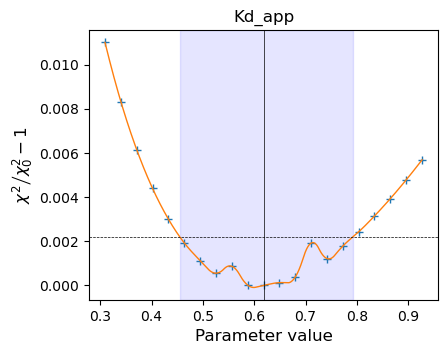

In [27]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)
axarr.set_xlabel('',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(r'',fontsize = mpl_ylabel_fontsize)
identi_koff_Kdapp[1].plot_ci("Kd_app",ax=axarr)

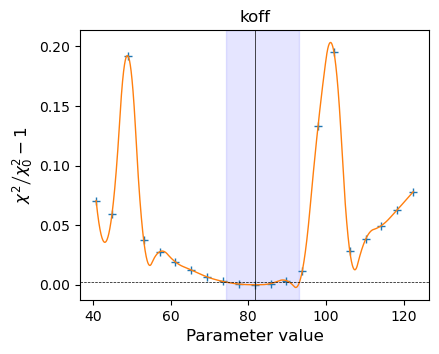

In [28]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)
axarr.set_xlabel('',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(r'',fontsize = mpl_ylabel_fontsize)
identi_koff_Kdapp[1].plot_ci("koff",ax=axarr)

In [29]:
del identi_koff_Kdapp
gc.collect()

24447

## Write fitted params to file

### Fitted koff and kon

In [30]:
# Set up df
data = {"Parameter": ["koff",
                     "kon",
                     "Kd_app"],
        "Value":[fit_koff_kon.params["koff"].value,
                fit_koff_kon.params["kon"].value,
                fit_koff_kon.params["Kd_app"].value]}
df_fitted_koff_kon_params = pd.DataFrame(data)
df_fitted_koff_kon_params.set_index("Parameter",inplace=True)
df_fitted_koff_kon_params

,Value
Parameter,
koff,102.306982
kon,93.006348
Kd_app,1.100000


In [31]:
# Write to file
df_fitted_koff_kon_params.to_csv(os.path.join(os.getcwd(),"fitted_koff_kon_PRDX1_params.csv"),
                                 sep=',',
                                 encoding='utf-8')
df_fitted_koff_kon_params.to_csv(os.path.join(par_dir,"fitted_koff_kon_PRDX1_params.csv"),
                                 sep=',',
                                 encoding='utf-8')


### Fitted Kd, koff and kon

In [32]:
# Set up df
data = {"Parameter": ["koff",
                     "kon",
                     "Kd_app"],
        "Value":[fit_Kd_koff_kon.params["koff"].value,
                fit_Kd_koff_kon.params["kon"].value,
                fit_Kd_koff_kon.params["Kd_app"].value]}
df_fitted_Kd_koff_kon_params = pd.DataFrame(data)
df_fitted_Kd_koff_kon_params.set_index("Parameter",inplace=True)
df_fitted_Kd_koff_kon_params

,Value
Parameter,
koff,1.897406e+02
kon,3.584959e-11
Kd_app,5.292685e+12


In [33]:
# Write to file
df_fitted_Kd_koff_kon_params.to_csv(os.path.join(os.getcwd(),"fitted_Kd_koff_kon_PRDX1_params.csv"), 
                                    sep=',', 
                                    encoding='utf-8')
df_fitted_Kd_koff_kon_params.to_csv(os.path.join(par_dir,"fitted_Kd_koff_kon_PRDX1_params.csv"),
                                    sep=',',
                                    encoding='utf-8')
